In [1]:
import sys
import csv

#import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
#%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]

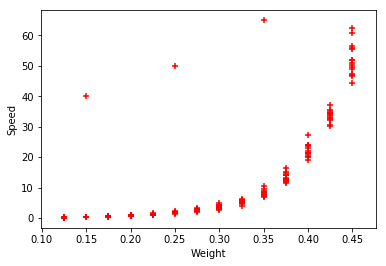

In [2]:
#Iscrtavanje linearne regresije
df = pd.read_csv("train.csv")

plt.xlabel('Weight')
plt.ylabel('Speed')
plt.scatter(df.X,df.Y, color='red', marker='+')

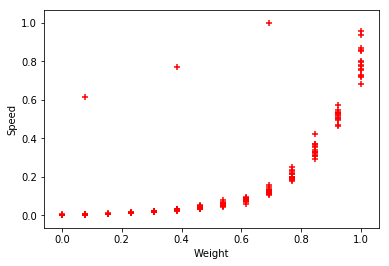

In [3]:
#Normalizacija podataka
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

df = normalize(df)
%matplotlib inline
plt.xlabel('Weight')
plt.ylabel('Speed')
plt.scatter(df.X, df.Y, color='red', marker='+')

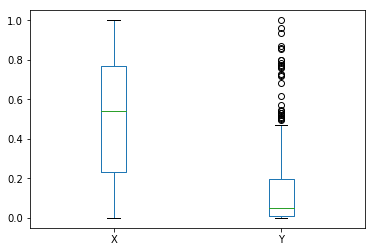

,X,Y
count,217.000000,217.000000
mean,0.492733,0.164912
std,0.313090,0.239037
min,0.000000,0.000000
25%,0.230769,0.011540
50%,0.538462,0.050469
75%,0.769231,0.197723
max,1.000000,1.000000


In [4]:
# #Boxplot da se vide outlieri
df.plot(kind='box')
plt.show()

df.describe()

Element number after IQR outlyer removed: 108


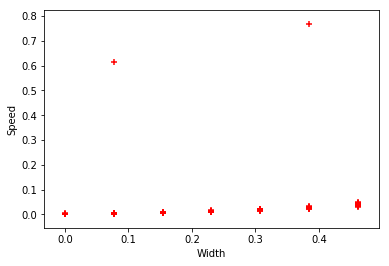

In [5]:
#PRONAZENJE PARAMETARA ZA OUTLIERE
def up_down(df):
    Q1 = df.describe().loc['25%']
    Q3 = df.describe().loc['75%']

    IQR_Weight = Q3[0] - Q1[0]
    IQR_Speed = Q3[1] - Q1[1]

    #Racunanje whiskera gore i dole
    UP_Weigth = Q3[0] + (1.5 *  IQR_Weight)
    DOWN_Weigth = Q1[0] - (1.5 *  IQR_Weight)

    UP_Speed = Q3[1] + (1.5 *  IQR_Speed)
    DOWN_Speed = Q1[1] - (1.5 *  IQR_Speed)

    return [UP_Weigth,DOWN_Weigth,UP_Speed,DOWN_Speed]

def up_down_z(df, sd):    
    STD = df.describe().loc['std']
    STDw = STD[0]
    STDsp = STD[1]

    MEAN = df.describe().loc['mean']
    MEANw = MEAN[0]
    MEANsp = MEAN[1]

    up_w = MEANw + sd * STDw;
    down_w = MEANw - sd * STDw;

    up_sp = MEANsp + sd * STDsp;
    down_sp = MEANsp - sd * STDsp;

    return [up_w,down_w,up_sp,down_sp]


def takeout_outliers(df, up_w, down_w, up_sp, down_sp):
    indexes = []
    counter = 0
    for i in df.Y:
        if i > up_w or i < down_w:
            indexes.append(counter)
        counter += 1

    counter = 0
    for i in df.X:
        if i > up_sp or i < down_sp:
            indexes.append(counter)
        counter += 1
    
    data = df.drop(indexes)
    return data


# IZBACIVANJE OUTLIERA
[up_w,down_w,up_sp,down_sp] = up_down_z(df, 1)
[up_w,down_w,up_sp,down_sp] = up_down(df)

df = takeout_outliers(df,up_w,down_w,up_sp,down_sp)

print("Element number after IQR outlyer removed: " + str(df.X.size))

%matplotlib inline
plt.xlabel('Width')
plt.ylabel('Speed')
plt.scatter(df.X,df.Y, color='red', marker='+')

In [6]:
#Racunanje RMSE
def RMSE(n,predicted, acctual):
    suma = 0
    for i in range(0, n):
        suma += (predicted[i] - acctual.iloc[i])**2
    return np.sqrt(suma/n)

In [7]:
#SORTED 80/20    
def train_test_split(dataset, data_size):
    train_counter = 1
    indices = []
    train = pd.DataFrame()
    dataframe_copy = dataset
    
    for i in range(data_size):
        if train_counter == 5:
            indices.append(i)
            train_counter = 1
        else:
            train_counter = train_counter + 1
    
    for i in range(len(indices)):
        train = train.append(dataframe_copy.iloc[[i]])
        
    
    return dataframe_copy.drop(labels = indices, axis=0), train   


from random import seed
from random import randrange

# Split a dataset into a train and test set
def train_test_split_random(dataset, data_size,split=0.7):
    
    train_size_counter = 0
    indices = []
    train = pd.DataFrame()
    train_size = split * data_size
    dataframe_copy = dataset
    while train_size_counter < train_size:
        train_size_counter = train_size_counter + 1
        index = randrange(data_size)
        indices.append(index)
    
    for i in range(len(indices)):
        train = train.append(dataframe_copy.iloc[[i]])
        
    return train, dataframe_copy.drop(labels = indices, axis=0)

In [8]:
def get_constants(df, n):
    x = df.X
    y = df.Y

    A = np.zeros((n, n))
    b = np.zeros((n, 1))

    for i in range(n):
        #print('row',i)
        for j in range(n):
            #print('column', j)
            #print(f'element sum(x**{i+j})')
            A[i,j]=sum(x**(i+j))
        #print("b element" + f"sum(x**{i}*y)")
        b[i] = sum(x**(i)*y)

    return np.dot(np.linalg.inv(A), b)

4.439477780612391

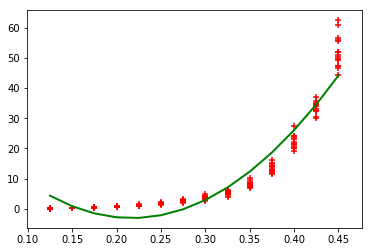

In [57]:
df_main = pd.read_csv("train.csv")

inda = [26, 149, 150]
df_main = df_main.drop(labels = inda, axis=0)
df_main = df_main.reset_index(drop=True)

[df_train, df_test] = train_test_split_random(df_main, df_main.Y.size, split=0.8)
#[df_train, df_test] = train_test_split(df_main, df_main.Y.size)


x = df_train.X
y = df_train.Y

z = get_constants(df_train,3)

a = float(z[2])
b = float(z[1])
c = float(z[0])

# y = []
# for x in df_test.X:
#     y.append(c + b * x + a * x * x)
    
y = []
for x in df_test.X:
    y.append(c + b*x + a*x*x)
        
n = df_test.Y.size

data = []
counter = 0
for element in df_test.X:
    data.append([element, y[counter] ])
    counter = counter + 1
    
df_unsorted = pd.DataFrame(data, columns = ['X', 'Y'])
df_sorted = df_unsorted.sort_values(by=['X'])
    
plt.scatter(df_main.X, df_main.Y, color='red', marker='+')
plt.plot(df_sorted.X, df_sorted.Y, color='green',linewidth=2, markersize=12)
RMSE(n, y, df_test.Y)

In [ ]:
# import sys

# if(len(sys.argv) != 3):
#     print("Mora imati dva argumenta 'train.csv' 'test.csv'")
#     exit()
# else:
#     train_csv = sys.argv[1]
#     test_csv = sys.argv[2]   
    
#     df_train = pd.read_csv(train_csv)
#     df_test = pd.read_csv(test_csv)

#     #[up_w,down_w,up_wi,down_wi] = up_down_z(df, 0.9)
#     #[up_w,down_w,up_wi,down_wi] = up_down(df)

#     #df = takeout_outliers(df,up_w,down_w,up_wi,down_wi)

#     x = df_train.X
#     y = df_train.Y
    
#     z = get_constants(df_train,6)

#     f = float(z[5])
#     e = float(z[4])
#     d = float(z[3])
#     a = float(z[2])
#     b = float(z[1])
#     c = float(z[0])

#     y = []
#     for x in df_test.X:
#         y.append(c + b*x + a*x*x + d*x*x*x + e*x*x*x*x + f*x*x*x*x*x )
 
#     n = df_test.X.size
#     print(RMSE(n, y, df_test.Y))
    
# #     plt.scatter(df.Width, df.Weight, color='red', marker='+')
# #     plt.plot(df.Width,y, color='green',linewidth=2, markersize=12)